In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Get a list of column names and types from measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types from measurement table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


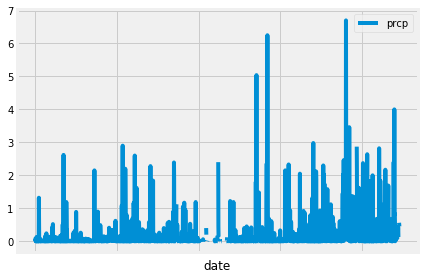

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
latest = np.ravel(session.query(Measurement.date)\
                         .order_by(Measurement.date.desc())\
                         .first())[0]

latest_date = dt.datetime.strptime(latest,'%Y-%m-%d')
one_year_before = latest_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
lastyear = session.query(Measurement.date,
                         Measurement.prcp)\
                  .filter(Measurement.date > one_year_before)\
                  .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
lastyear_df = pd.DataFrame(lastyear)
lastyear_df.set_index('date', inplace=True)

# Sort the dataframe by date
lastyear_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
lastyear_df.plot()
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyear_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
len(session.query(Measurement.station)\
            .group_by(Measurement.station)\
            .all())

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity_levels = session.query(Measurement.station,
                                func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()

print(activity_levels)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs))\
        .filter(Measurement.station == activity_levels[0][0])\
        .all()

[(54.0, 85.0, 71.66378066378067)]

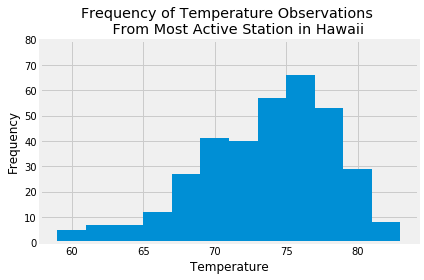

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_past_year = session.query(Measurement.date, Measurement.tobs)\
                               .filter(Measurement.date > one_year_before,
                                       Measurement.station == activity_levels[0][0])\
                               .all()

mapy_df = pd.DataFrame(most_active_past_year)
mapy_df.set_index('date')

mapy_df.hist(bins=12)
plt.yticks(np.arange(0,max(mapy_df['tobs']),10))

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'''Frequency of Temperature Observations 
    From Most Active Station in Hawaii''')

plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Choosing trip dates of 2018-06-01 to 2018-06-16
trip_dates = calc_temps('2017-06-01','2017-06-16')
td_stats = [i for i in trip_dates[0]]
print(td_stats)

[72.0, 77.40384615384616, 83.0]


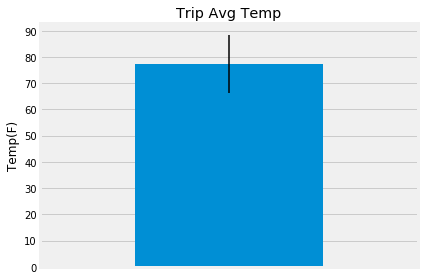

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()

ax.bar(0.4,
       td_stats[1],
       yerr=(td_stats[2] - td_stats[0]),
       width=0.4,
       error_kw={'elinewidth':1.5})

ax.set_xlim(0,0.8)
ax.set_yticks(np.arange(0,100,10))
ax.xaxis.grid(False)

ax.set_xticklabels('')

ax.set_ylabel('Temp(F)')
ax.set_title('Trip Avg Temp')

fig.tight_layout()
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_last_trip_date = session.query(Station.station,
                                        Station.name,
                                        Station.latitude,
                                        Station.longitude,
                                        Station.elevation,
                                        func.sum(Measurement.prcp))\
                                 .filter(Measurement.station == Station.station)\
                                 .filter(Measurement.date>dt.datetime(2017,6,1),
                                         Measurement.date<dt.datetime(2017,6,16))\
                                 .group_by(Station.station)\
                                 .order_by(func.sum(Measurement.prcp).desc())\
                                 .all()
rainfall_last_trip_date

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.6),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.0400000000000005),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.04),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.9500000000000002),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.76),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
dates = []

# Set the start and end date of the trip
start = dt.date(2017,6,1)
end = dt.date(2017,6,16)
day = dt.timedelta(days=1)

# Use the start and end date to create a range of dates
while start < end:
    dates.append("{date.month:02}-{date.day:02}".format(date=start))
    start += day

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = {}
for date in dates:
    normals[date] = daily_normals(date)[0]
print(normals)

{'06-01': (64.0, 74.6140350877193, 81.0), '06-02': (65.0, 74.4, 81.0), '06-03': (65.0, 74.03448275862068, 80.0), '06-04': (65.0, 73.81818181818181, 81.0), '06-05': (68.0, 74.85454545454546, 81.0), '06-06': (70.0, 75.17543859649123, 80.0), '06-07': (68.0, 75.07142857142857, 81.0), '06-08': (70.0, 75.58620689655173, 81.0), '06-09': (69.0, 75.15254237288136, 81.0), '06-10': (68.0, 75.14285714285714, 81.0), '06-11': (69.0, 76.01960784313725, 84.0), '06-12': (66.0, 75.66666666666667, 83.0), '06-13': (68.0, 75.66666666666667, 81.0), '06-14': (69.0, 75.62711864406779, 81.0), '06-15': (67.0, 75.40350877192982, 81.0)}


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals).T
normals_df.columns = ['tmin','tavg','tmax']
normals_df

,tmin,tavg,tmax
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0
06-10,68.0,75.142857,81.0


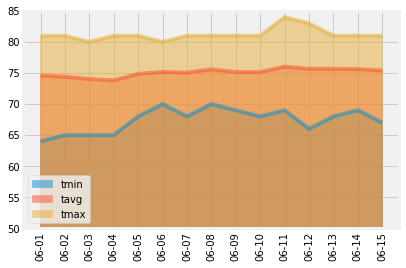

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False, ylim=(50,85))
plt.xticks(range(15), normals_df.index, rotation=90)
plt.show()